In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [3]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [4]:
# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image

In [5]:
# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])


In [6]:
# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)

Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [19]:
def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation Block"""
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

from tensorflow.keras.layers import Lambda

def spatial_attention_block(input_tensor):
    """Spatial Attention Block"""
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])  
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([input_tensor, attention])


def residual_block(input_tensor, filters, kernel_size=3, stride=1):
    """Residual Block with SE and Spatial Attention"""
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)
    x = spatial_attention_block(x)
    
    if input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [21]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input, Add, Activation, Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.models import Model

input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 112, 112, 64)   │            256 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 56, 56, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 56, 56, 64)     │            256 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 56, 56, 64)     │            256 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_4… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 64)             │            320 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_13 (Reshape)      │ (None, 1, 1, 64)       │              0 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_21 (Multiply)    │ (None, 56, 56, 64)     │              0 │ batch_normalization_4… │
│                           │                        │                │ reshape_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_20 (Lambda)        │ (None, 56, 56, 1)      │              0 │ multiply_21[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_21 (Lambda)        │ (None, 56, 56, 1)      │              0 │ multiply_21[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 56, 56, 2)      │              0 │ lambda_20[0][0],       │
│ (Concatenate)        

 Total params: 11,549,592 (44.06 MB)

 Trainable params: 11,538,968 (44.02 MB)

 Non-trainable params: 10,624 (41.50 KB)

In [24]:
from tensorflow.keras.optimizers import Adam


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Modeli derliyoruz
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy verilerle eğitim örneği
# Burada X_train, y_train, X_val ve y_val'yi kendi verilerinizle değiştirin
epochs = 100
batch_size = 32

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 366ms/step - accuracy: 0.3003 - loss: 5.7494 - val_accuracy: 0.1123 - val_loss: 5.6122 - learning_rate: 1.0000e-04
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4437 - loss: 5.1797 - val_accuracy: 0.1137 - val_loss: 5.6898 - learning_rate: 1.0000e-04
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4911 - loss: 4.9615 - val_accuracy: 0.1433 - val_loss: 5.9191 - learning_rate: 1.0000e-04
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5013 - loss: 4.8365 - val_accuracy: 0.1758 - val_loss: 6.0256 - learning_rate: 1.0000e-04
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5341 - loss: 4.6285 - val_accuracy: 0.1846 - val_loss: 6.0738 - learning_rate: 1.0000e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5639 - loss: 4.4742 - val_accuracy: 0.3043 - val_loss: 5.0869 - learning_rate: 1.0000e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy

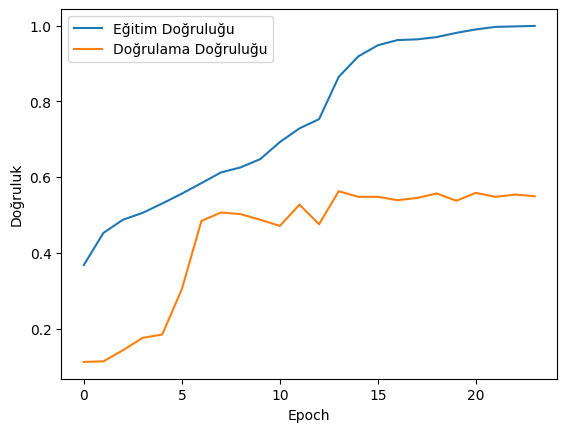

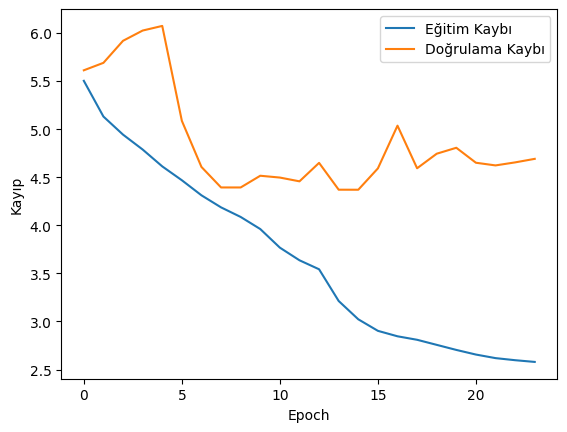

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5506 - loss: 4.3422
Test Kaybı: 4.408921241760254
Test Doğruluğu: 0.5465288162231445


In [25]:
# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Modeli kaydedin (isteğe bağlı)
model.save('model.h5')  # veya farklı bir format

# Modeli değerlendirin (isteğe bağlı)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {loss}")
print(f"Test Doğruluğu: {accuracy}")

In [7]:
print(y_train.shape)  # Hedef veri şekli
print(X_train.shape)  # Girdi veri şekli

(3158, 8)
(3158, 224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 200)       │           5,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 220, 220, 180)       │         324,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 44, 44, 180)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 42, 42, 180)         │         291,780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 40, 40, 140)         │         226,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 38, 38, 100)         │         126,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 36, 36, 50)          │          45,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2450)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 180)                 │         441,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,484,388 (5.66 MB)

 Trainable params: 1,484,388 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

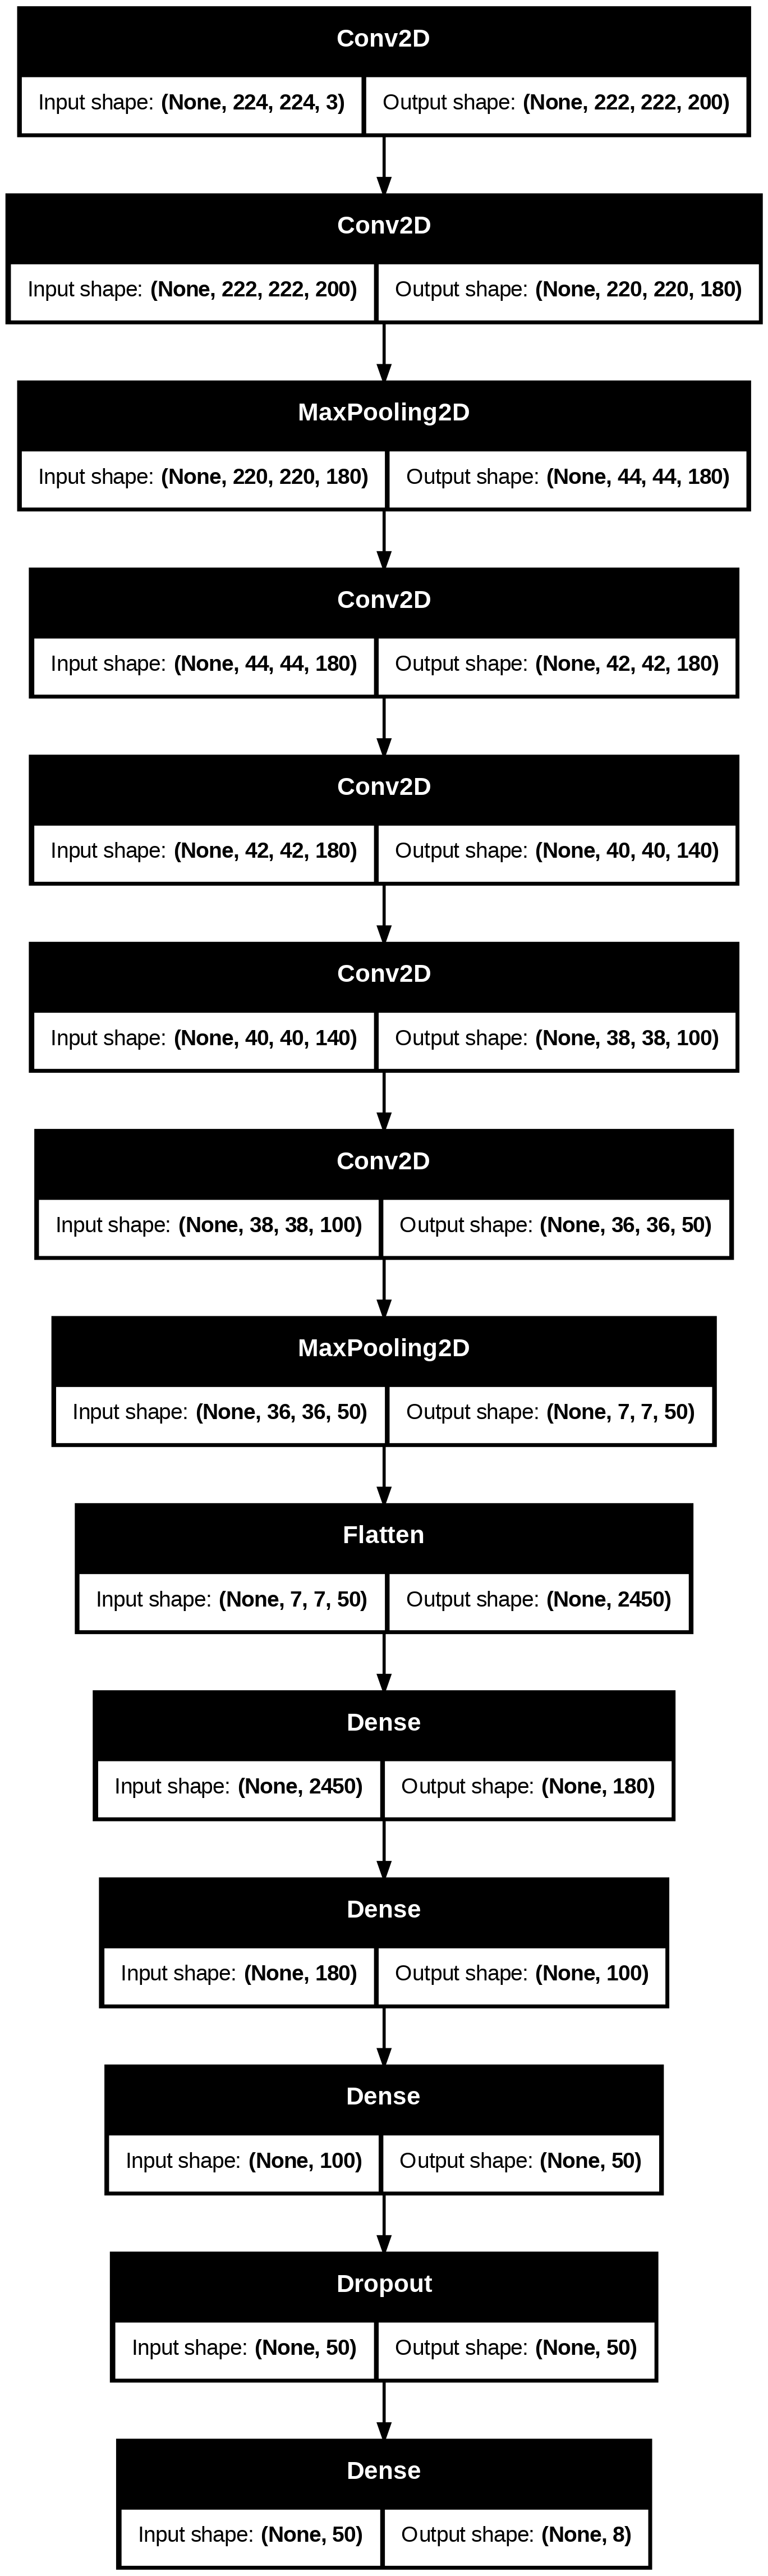

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Model oluşturma
model = Sequential()

model.add(Conv2D(200, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(180, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(180, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(140, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Flatten())
model.add(Dense(180, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(8, activation='softmax'))

# Model derleme
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini gösterme
model.summary()

# Model grafiğini çizme
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True)


In [12]:
from tensorflow.keras.optimizers import Adam


# Training the Model
with tf.device('/GPU:0'):
    epochs = 100
    history1 = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 124s 756ms/step - accuracy: 0.1533 - loss: 2.0639 - val_accuracy: 0.2555 - val_loss: 1.9356
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.2504 - loss: 1.9285 - val_accuracy: 0.3575 - val_loss: 1.6645
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.3489 - loss: 1.7513 - val_accuracy: 0.4579 - val_loss: 1.5224
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.3819 - loss: 1.6805 - val_accuracy: 0.4372 - val_loss: 1.4604
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.4160 - loss: 1.5947 - val_accuracy: 0.4904 - val_loss: 1.3895
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.4306 - loss: 1.5441 - val_accuracy: 0.4934 - val_loss: 1.3613
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.4445 - loss: 1.4913 - val_accuracy: 0.4742 - val_loss: 1.3760
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.4692 - loss: 1.4536 -

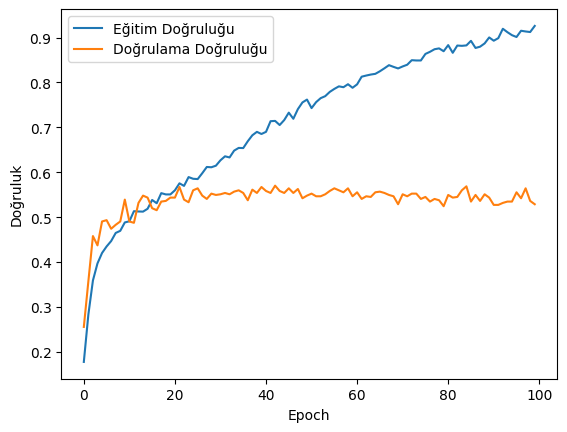

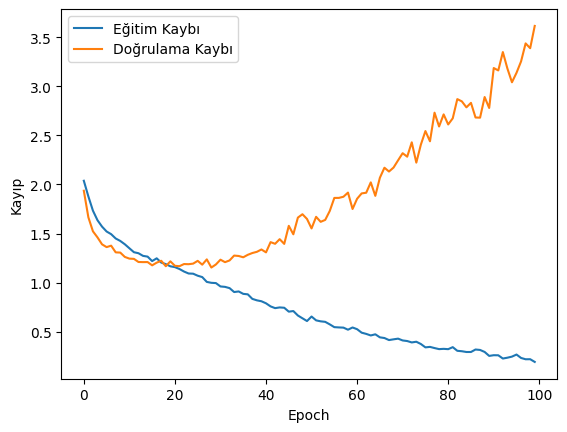

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5315 - loss: 3.5814
Test Kaybı: 3.574694871902466
Test Doğruluğu: 0.5347119569778442


In [14]:
# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history1.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='Eğitim Kaybı')
plt.plot(history1.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Modeli kaydedin (isteğe bağlı)
model.save('model.h5')  # veya farklı bir format

# Modeli değerlendirin (isteğe bağlı)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {loss}")
print(f"Test Doğruluğu: {accuracy}")